# Import JSON Database and create numpy arrays

In [1]:
import os

current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','0. Create DB','database5SS_n2500_json.txt')

In [2]:
import json
with open(db_path) as f:
    json_data = json.load(f)
#print(json.dumps(json_data, indent=4))

In [3]:
import numpy as np

MechList=[];
CplrPathList=[];
for d in json_data:
    MechList.append(np.asarray(d["Mech"]))
    CplrPathList.append(np.asarray(d["CplrPath"]))

In [4]:
print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

(2500, 11, 3)
(2500,)


# Import .MAT Database and create numpy arrays

In [5]:
import os

current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','0. Create DB','database5SS_n7500_mat.mat')

In [6]:
from scipy.io import loadmat

matData = loadmat(db_path)
MechList=matData['Mech'][0]
CplrPathList=matData['CplrPath'][0]

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

(7500,)
(7500,)


# Plot sample Coupler curve data

In [7]:
#%matplotlib inline
%matplotlib notebook

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from numpy import linalg as LA


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

<IPython.core.display.Javascript object>


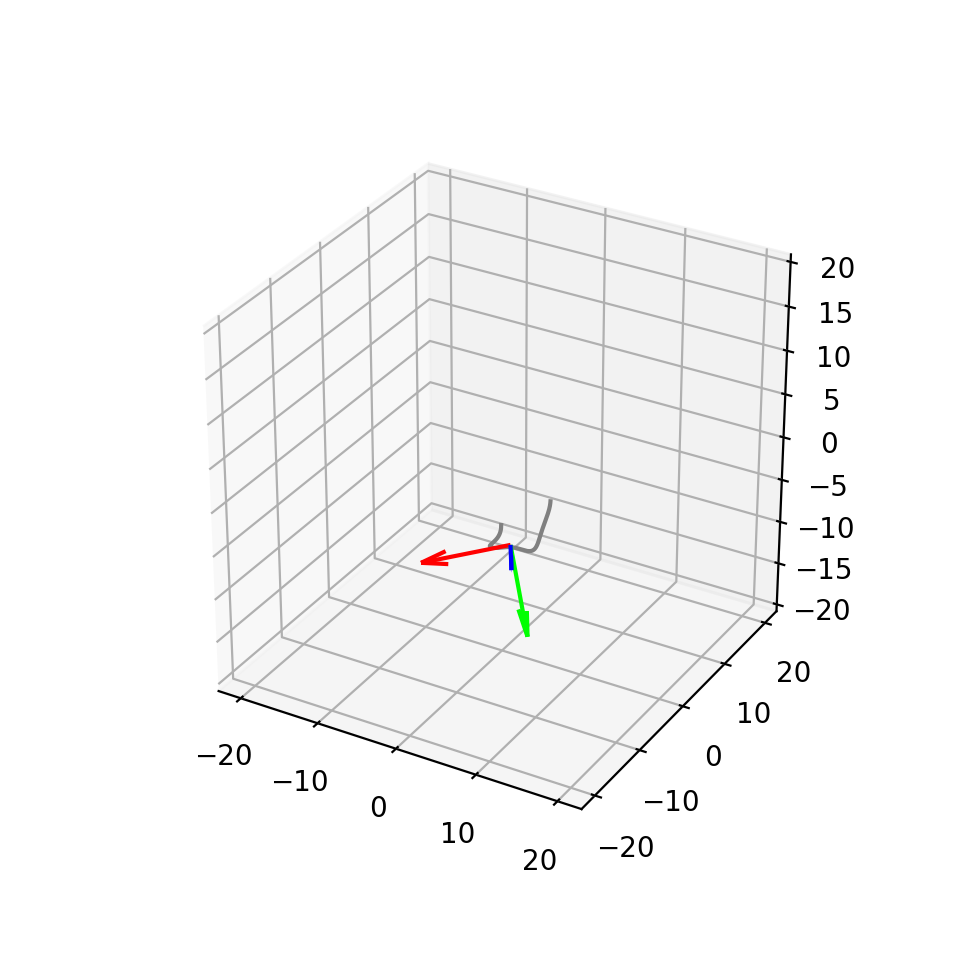

In [8]:
Pts=CplrPathList[21]
fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(Pts, ax, 20)
        
C=np.mean(Pts,axis=0)
Covariance_Mat=np.cov(Pts,rowvar=0)
sing_vec=LA.svd(Covariance_Mat)[0]
R=sing_vec.T*10
plotXYZ(C, R, ax)

<IPython.core.display.Javascript object>


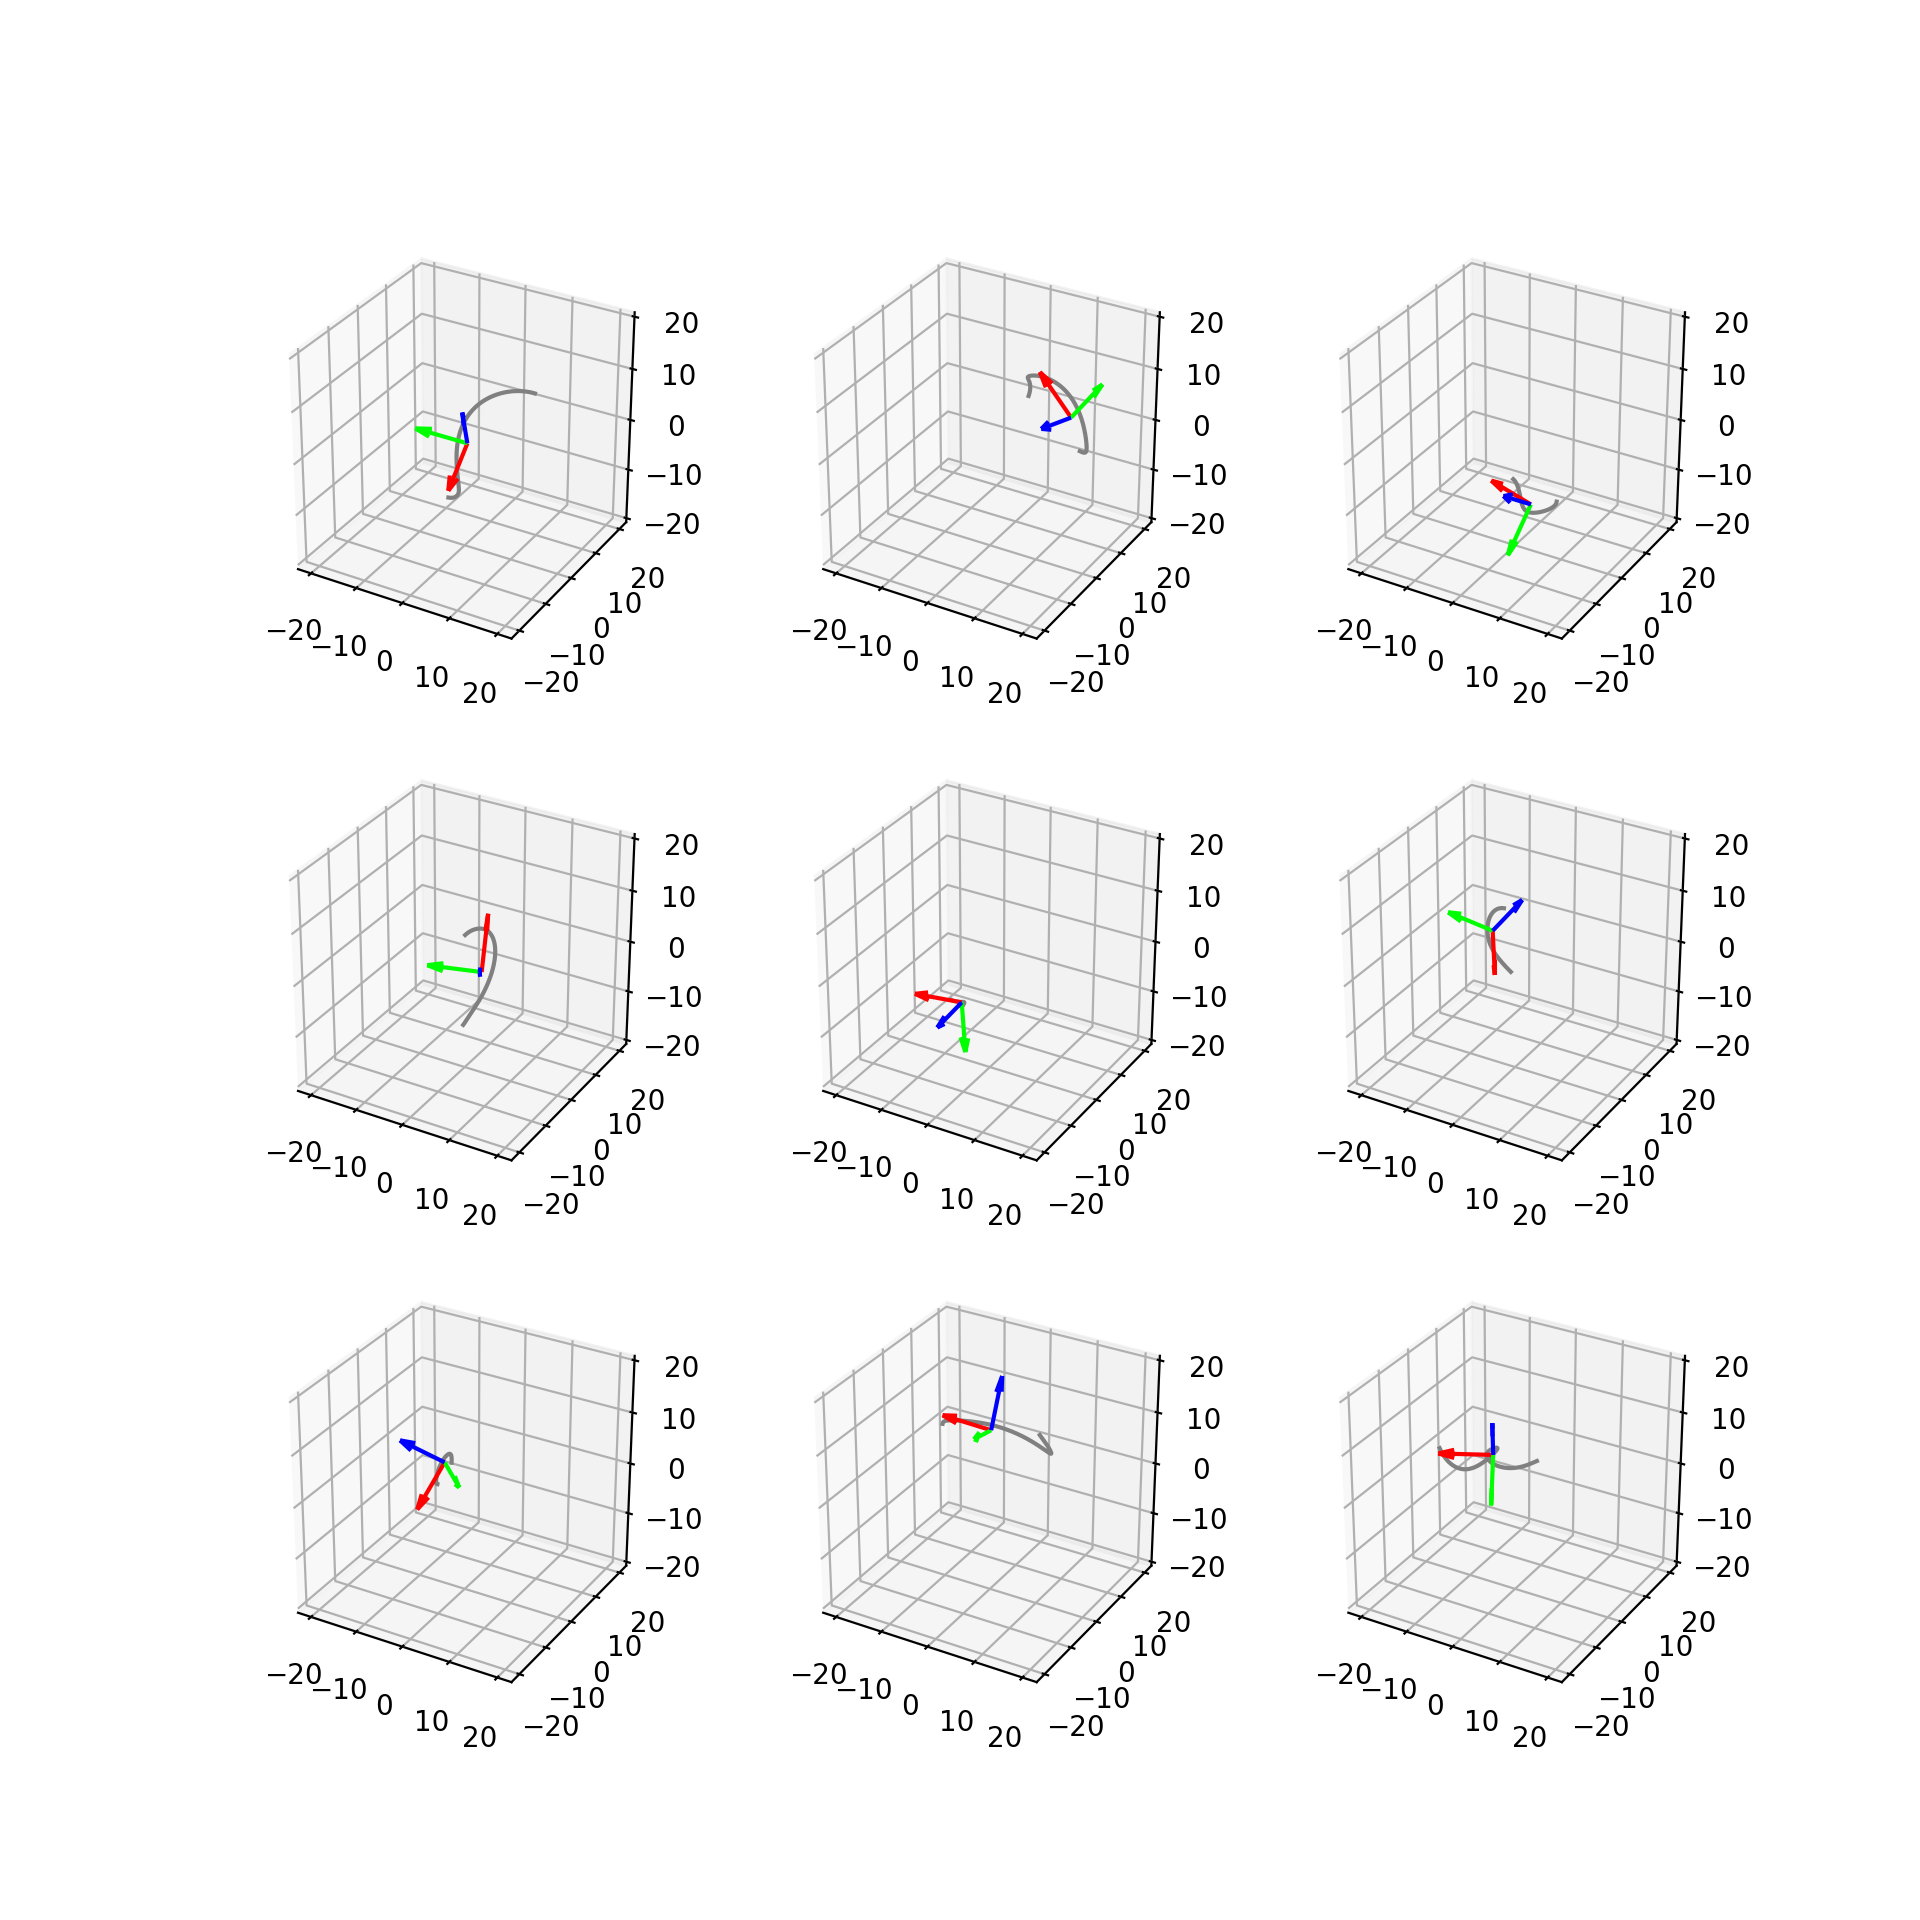

In [9]:
rows=3
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(cols/rows))
for i in range(rows):
    for j in range(cols):
        Pts=CplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(cols, rows, path_index, projection='3d')
        plotPath(Pts, ax, 20)
        
        C=np.mean(Pts,axis=0)
        Covariance_Mat=np.cov(Pts,rowvar=0)
        sing_vec=LA.svd(Covariance_Mat)[0]
        R=sing_vec.T*10
        plotXYZ(C, R, ax)

# Remove Coupler paths with too less data

As can be seen in the histogram, the number of points in each coupler path ranges from 2 to 3126 points. We ignore paths having less than 10 datapoints

<IPython.core.display.Javascript object>


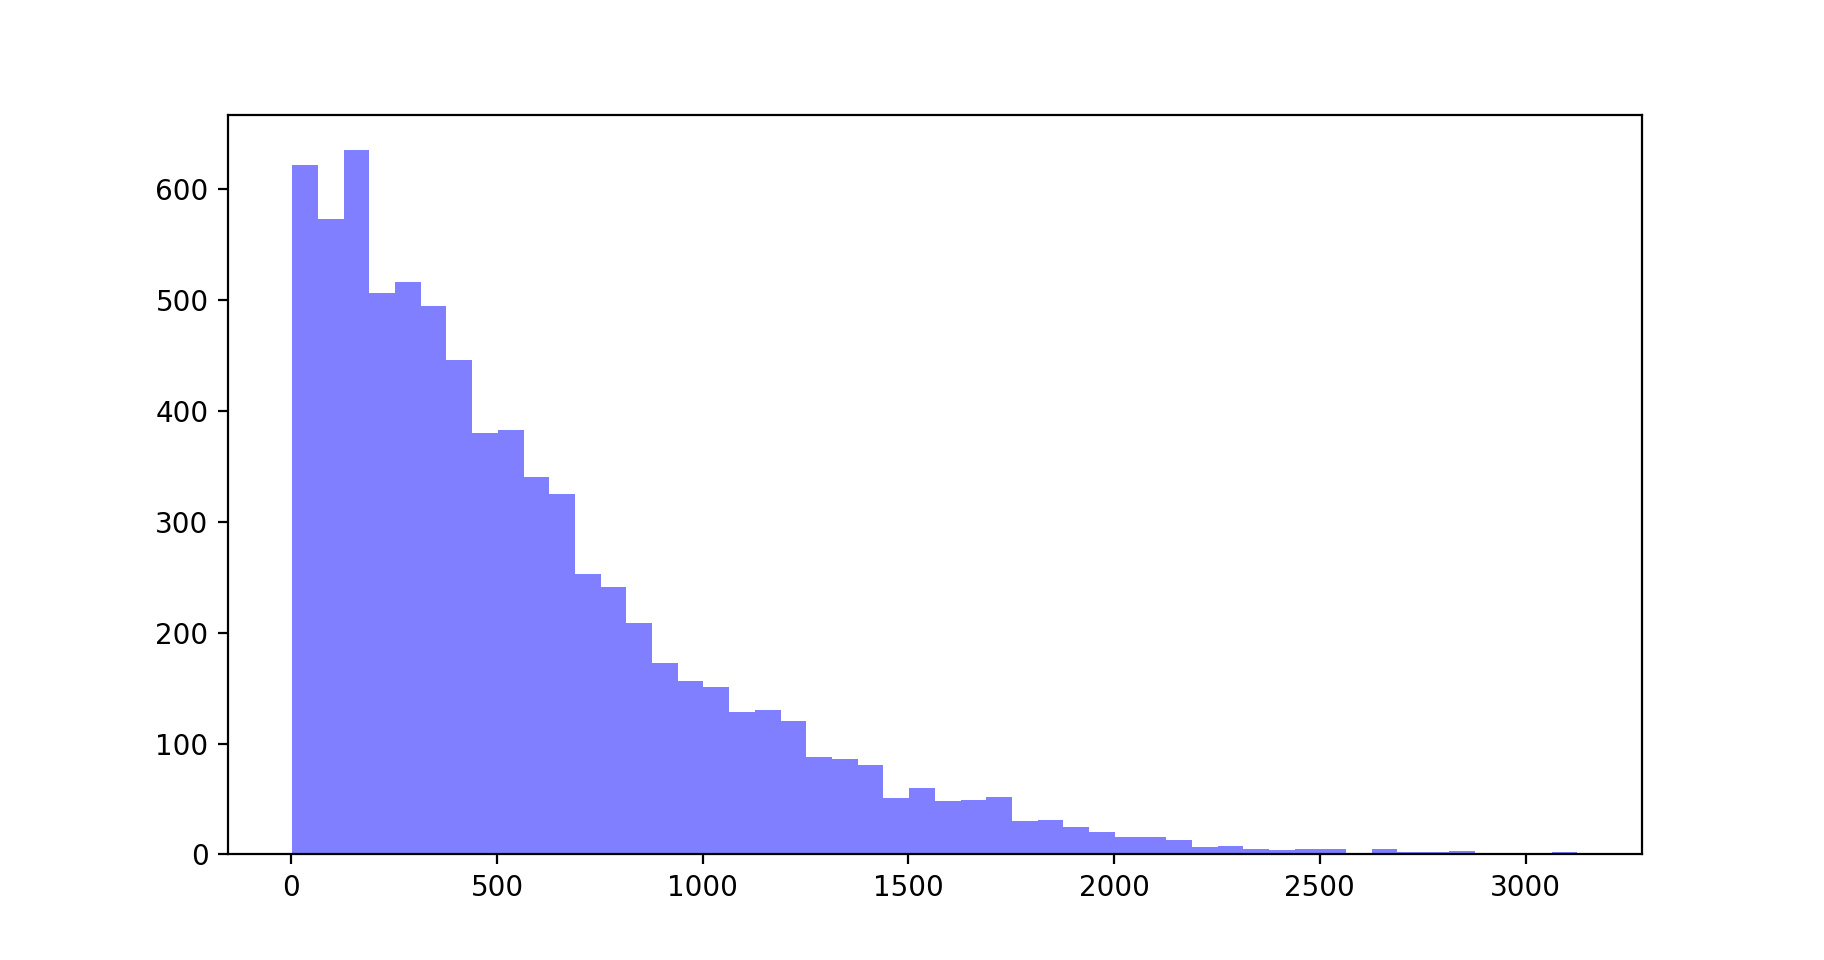

The minimum number of points in a coupler curve are: 2
The maximum number of points in a coupler curve are: 3126


In [10]:
no_Path_Pts=[];
for i in range(len(CplrPathList)):
    no_Path_Pts.append(CplrPathList[i].shape[0])

fig = plt.figure(figsize=1*plt.figaspect(1/1.9))
n, bins, patches = plt.hist(no_Path_Pts, 50, facecolor='blue', alpha=0.5)
plt.show()

print("The minimum number of points in a coupler curve are: "+ str(min(no_Path_Pts)))
print("The maximum number of points in a coupler curve are: "+ str(max(no_Path_Pts)))

In [11]:
# Remove Data with less than 10 points due to too less curve data
print("Database size before removing data: " + str(len(CplrPathList)))
no_Path_Pts=np.array(no_Path_Pts)
leq10_index=np.where(no_Path_Pts<10)

CplrPathList=np.delete(CplrPathList, leq10_index)
MechList=np.delete(MechList, leq10_index, axis=0)
print("Database size after removing data: " + str(len(CplrPathList)))

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

Database size before removing data: 7500
Database size after removing data: 7408
(7408,)
(7408,)


# Normalize number of points in each path to 100 pts using B-spline curves

To use it in a ML framework, we resample each curve and normalize them to contain 100 points each.

In [12]:
from scipy import interpolate

def normalizePathPts(Path, num_pts=100):
    xp=Path[:,0]
    yp=Path[:,1]
    zp=Path[:,2]
    
    # Check for duplicate points as interpolation routine errors out
    okay = np.where(np.abs(np.diff(xp)) + np.abs(np.diff(yp)) + np.abs(np.diff(zp)) > 0)
    xp = np.r_[xp[okay], xp[-1]]
    yp = np.r_[yp[okay], yp[-1]]
    zp = np.r_[zp[okay], zp[-1]]

    # Fit cubic B-spline to the data points
    tck, u =interpolate.splprep([xp,yp,zp],s=.01)
    u_fine = np.linspace(0,1,num_pts)
    x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
    Path_100 = np.vstack(([x_100],[y_100],[z_100])).T
    
    return Path_100

<IPython.core.display.Javascript object>


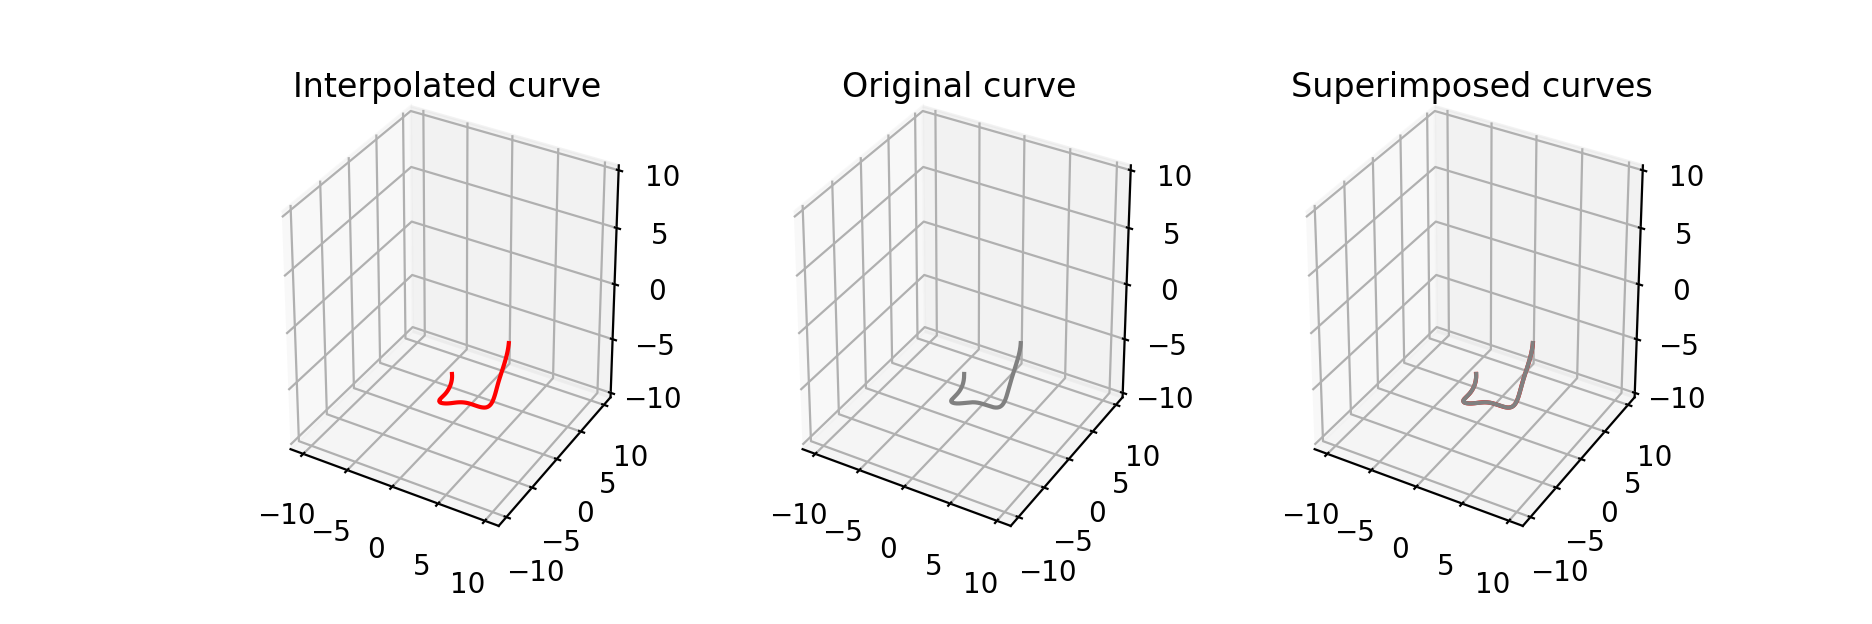

In [13]:
# Visualize how well the fitted curve reflects original data

Path=CplrPathList[21]
Path_100=normalizePathPts(Path)

fig = plt.figure(figsize=.65*plt.figaspect(1/3))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plt.title("Interpolated curve")
plotPath(Path_100, ax, 10, color='r')
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.title("Original curve")
plotPath(Path, ax, 10, color='grey')
ax = fig.add_subplot(1, 3, 3, projection='3d')
plt.title("Superimposed curves")
plotPath(Path_100, ax, 10, color='r')
plotPath(Path, ax, 10, color='grey')

In [14]:
MechList100=MechList;
CplrPathList100=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList[i]
    Path_100=normalizePathPts(Path)
    CplrPathList100.append(Path_100)

# Normalize Data (Translation,Rotation, Scaling)

- Translation: Average of all points moved to origin.
- Rotation: Principal axes rotated to align with x-axis
- Scaling: Divide points by maximum coordinate to bound curve in (-1,1) bounding box

In [15]:
def normalizePath(Path):
    #TRANSLATION
    T=np.mean(Path,axis=0)
    Trans_Path=Path-T

    #ROTATION
    Covariance_Mat=np.cov(Trans_Path,rowvar=0)
    sing_vec=LA.svd(Covariance_Mat)[0]
    R=sing_vec.T
    Rot_Path=np.matmul(R,Trans_Path.T).T
    
    #SCALING
    #S=np.max(np.std(Rot_Path,axis=0)) # Scale according to max st dev
    S=np.max(np.abs(Rot_Path)) # Scale largest dim to 1/-1 bound
    Scale_Path=Rot_Path/S

    return Scale_Path, T, R, S

def normalizeMech(Mech, Translate, Rotate, Scale):
    Trans_Mech=Mech-Translate
    Rot_Mech=np.matmul(Rotate,Trans_Mech.T).T
    Scale_Mech=Rot_Mech/Scale
    return Scale_Mech

In [16]:
Norm100MechList=[];
Norm100CplrPathList=[];

for i in range(len(CplrPathList)):
    Path=CplrPathList100[i]
    Mech=MechList100[i]
    
    nPath, T, R, S=normalizePath(Path)
    nMech=normalizeMech(Mech, T, R, S)
    
    Norm100MechList.append(nMech)
    Norm100CplrPathList.append(nPath)

print(np.array(MechList).shape)
print(np.array(CplrPathList).shape)

(7408,)
(7408,)


<IPython.core.display.Javascript object>


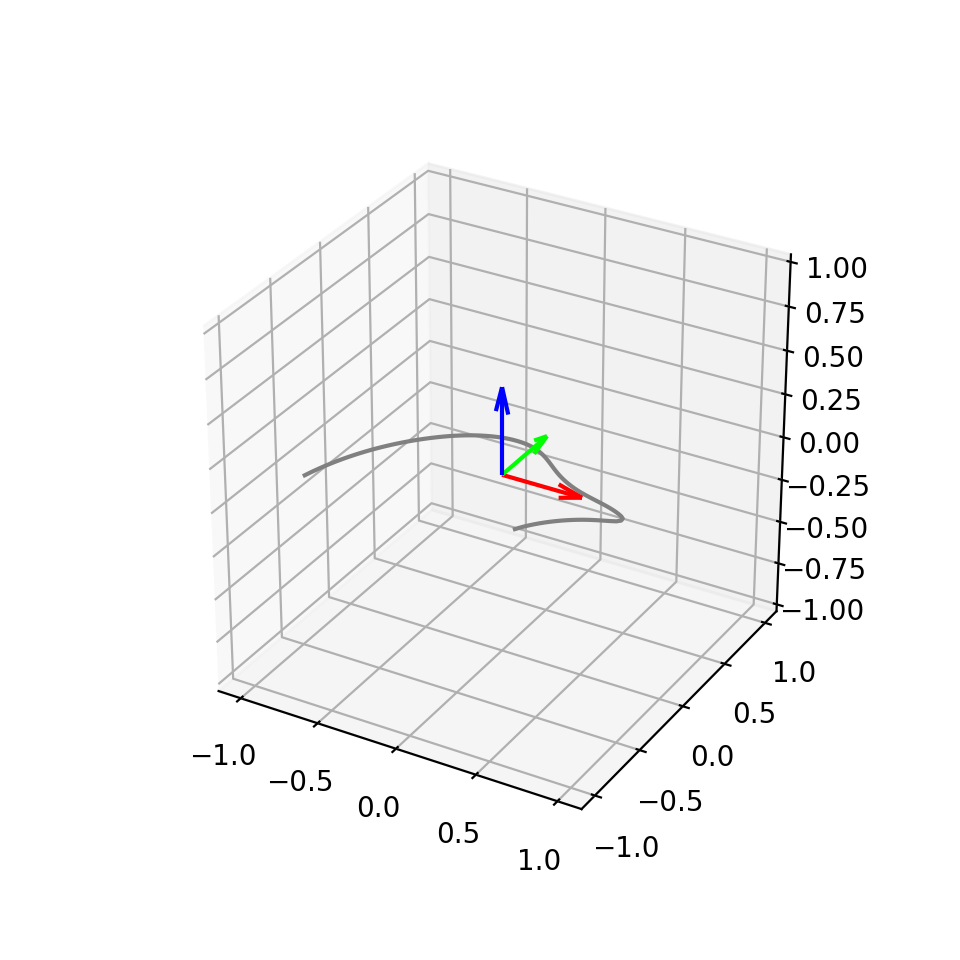

In [17]:
nPath=Norm100CplrPathList[21]

fig = plt.figure(figsize=1*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plotPath(nPath, ax, 1)
plotXYZ(np.zeros((1, 3)), np.identity(3)/2, ax)

# Normalize coordinates in x, y, z axis independently (NOT USED)

Due to our path normalization technique, we orient maximum variance direction with x axis and minimum variance in z axis. This bias leads to the VAE learning X and Y axis data predominanity. Due to this each axis data need to be scaled independently for better fit. However, the aspect ration of the path is not conserved due to this operation and the paths we get are not coupler paths. Thus we ignore this operation

In [18]:
def scalePath(Path):
    S=np.std(Path,axis=0)
    Scale_Path=[]
    Scale_Path.append(Path[:,0]/S[0])
    Scale_Path.append(Path[:,1]/S[1])
    Scale_Path.append(Path[:,2]/S[2])
    return np.asarray(Scale_Path).T

Skewed100CplrPathList=[];
for i in range(len(Norm100CplrPathList)):
    spath=Norm100CplrPathList[i]
    Skewed100CplrPathList.append(scalePath(spath))

<IPython.core.display.Javascript object>


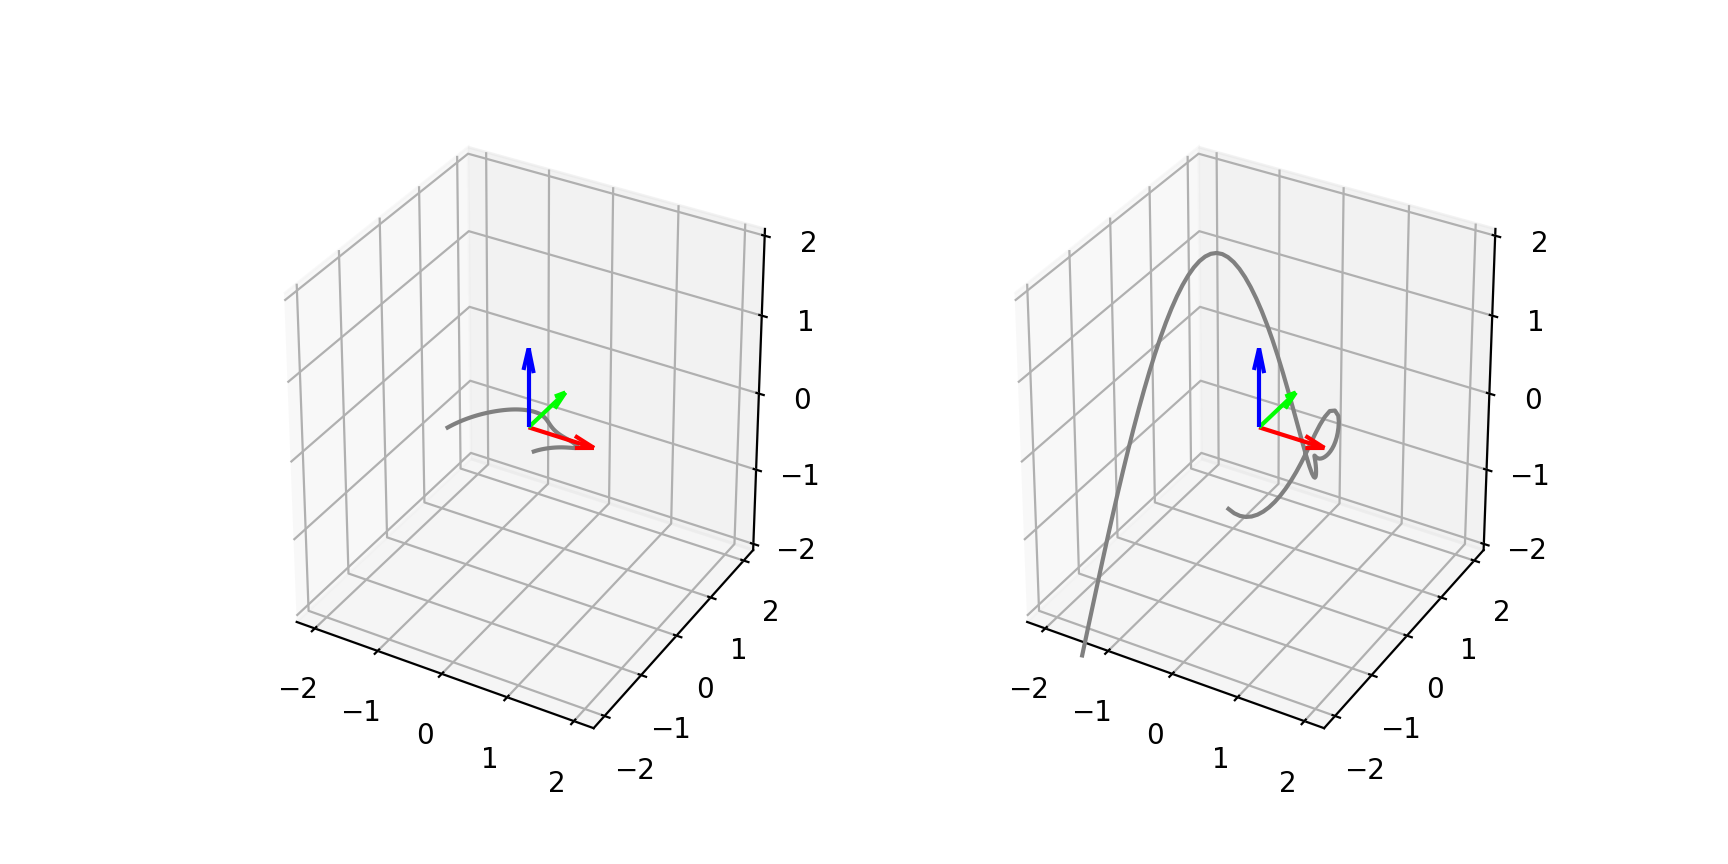

In [19]:
nPath=Norm100CplrPathList[21]
sPath=Skewed100CplrPathList[21]

fig = plt.figure(figsize=.9*plt.figaspect(1/2))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plotPath(nPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
ax = fig.add_subplot(1, 2, 2, projection='3d')
plotPath(sPath, ax, 2)
plotXYZ(np.zeros((1, 3)), np.identity(3), ax)

# Normalize the variety of data

In its present state, the database has more samples of coupler paths which are more probable while lesser samples of other more diverse. However, we would like our NN to handle all types of coupler paths with same efficiency and accuracy. To overcome this bias, we select a limited number of diverse paths from the complete database. Thus, this new balanced dataset contains equal samples of unique and diverse paths.

In [20]:
normThreshold=.01
DiverseCplrPathList=np.array([Norm100CplrPathList[0]])
DiverseMechList=np.array([Norm100MechList[0]])

for i in range(1,len(Norm100CplrPathList)):
    if i%500==0:
        print("Paths Processed:"+ str(i)+" ,unique Paths in DB:"+str(DiverseCplrPathList.shape[0]))
    
    path1=Norm100CplrPathList[i]
    mech1=Norm100MechList[i]
    diff=np.array([])
    
    for path2 in DiverseCplrPathList:
        d=LA.norm(path1-path2)/100
        diff=np.append(diff,[d])
    
    if diff.min()>normThreshold:
        DiverseCplrPathList=np.append(DiverseCplrPathList,[path1], axis=0)
        DiverseMechList=np.append(DiverseMechList,[mech1], axis=0)
        
print("Database size before removing similar paths: " + str(np.array(Norm100CplrPathList).shape[0]))
print("Database size after removing similar paths: " + str(DiverseCplrPathList.shape[0]))

Paths Processed:500 ,unique Paths in DB:208
Paths Processed:1000 ,unique Paths in DB:380
Paths Processed:1500 ,unique Paths in DB:537
Paths Processed:2000 ,unique Paths in DB:668
Paths Processed:2500 ,unique Paths in DB:791
Paths Processed:3000 ,unique Paths in DB:905
Paths Processed:3500 ,unique Paths in DB:1035
Paths Processed:4000 ,unique Paths in DB:1157
Paths Processed:4500 ,unique Paths in DB:1275
Paths Processed:5000 ,unique Paths in DB:1394
Paths Processed:5500 ,unique Paths in DB:1515
Paths Processed:6000 ,unique Paths in DB:1611
Paths Processed:6500 ,unique Paths in DB:1711
Paths Processed:7000 ,unique Paths in DB:1815
Database size before removing similar paths: 7408
Database size after removing similar paths: 1902


<IPython.core.display.Javascript object>


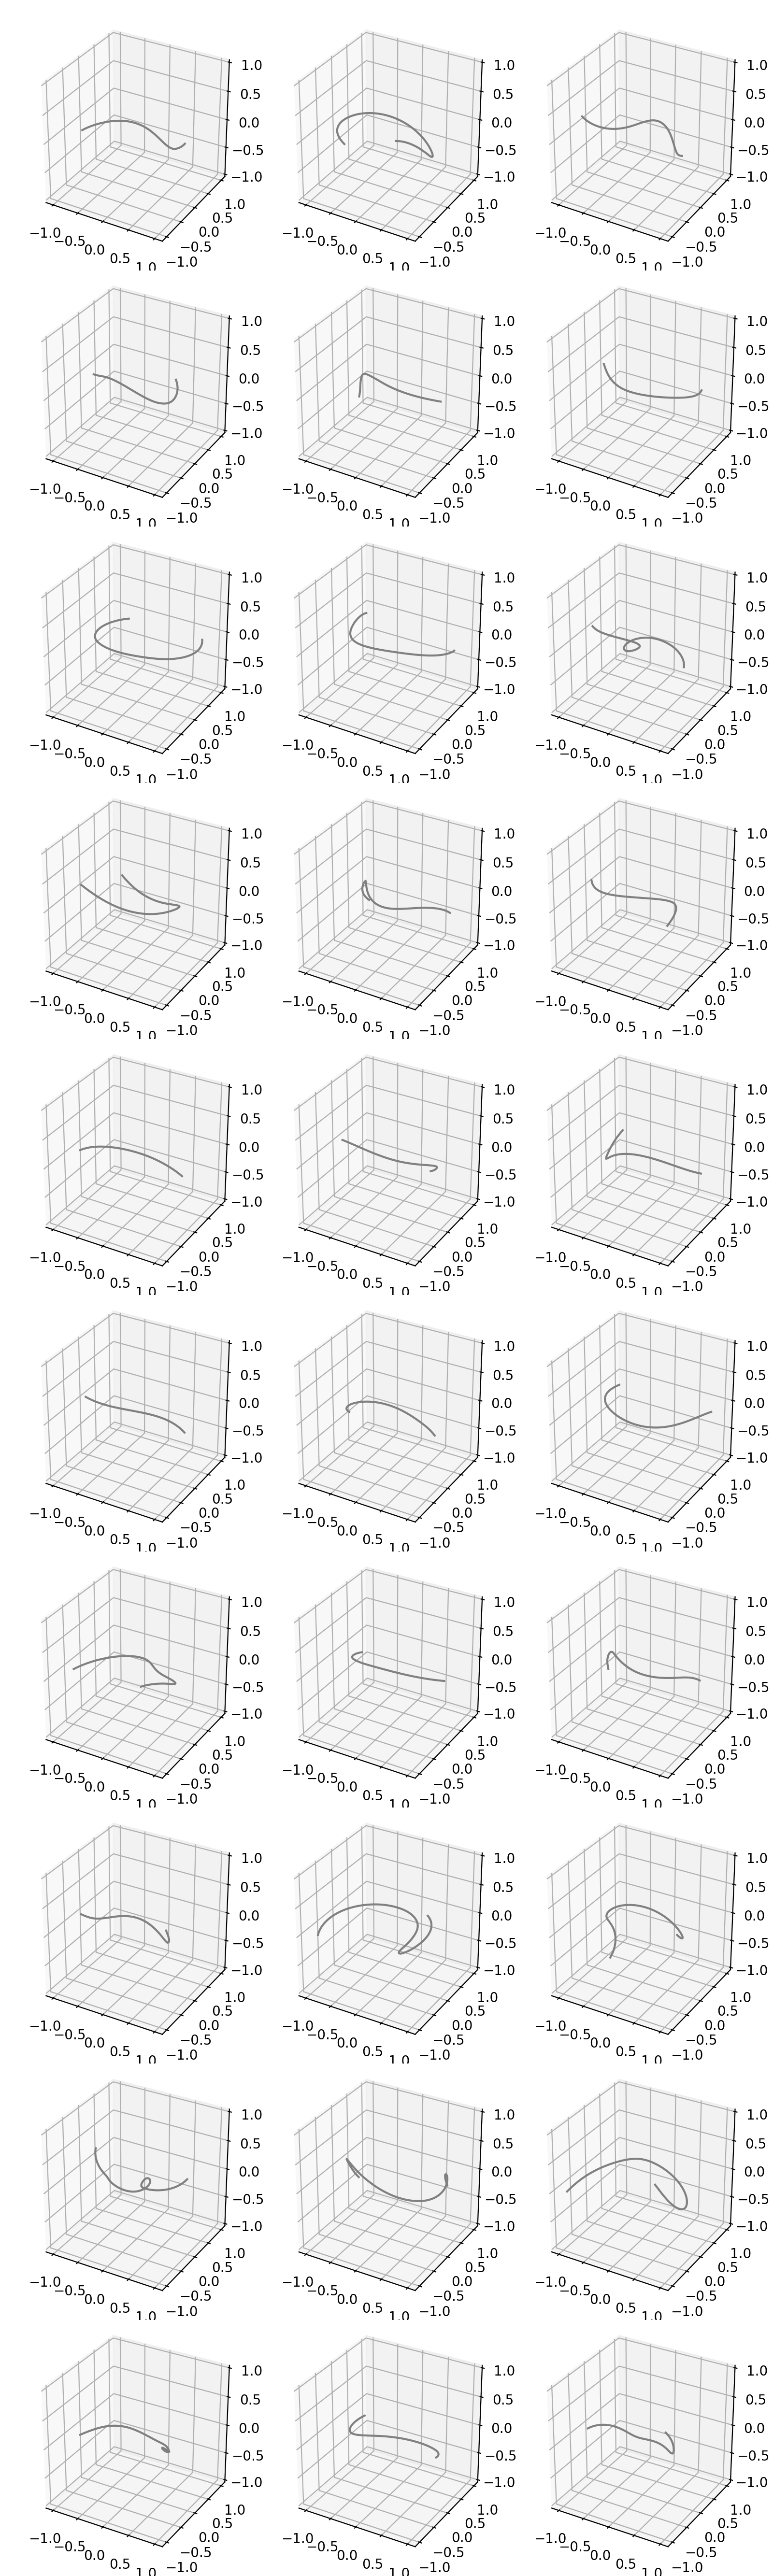

In [21]:
rows=10
cols=3

path_index=0;
fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
for i in range(rows):
    for j in range(cols):
        Pts=DiverseCplrPathList[path_index]
        path_index=path_index+1
        ax = fig.add_subplot(rows, cols, path_index, projection='3d')
        plotPath(Pts, ax, 1)
        #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


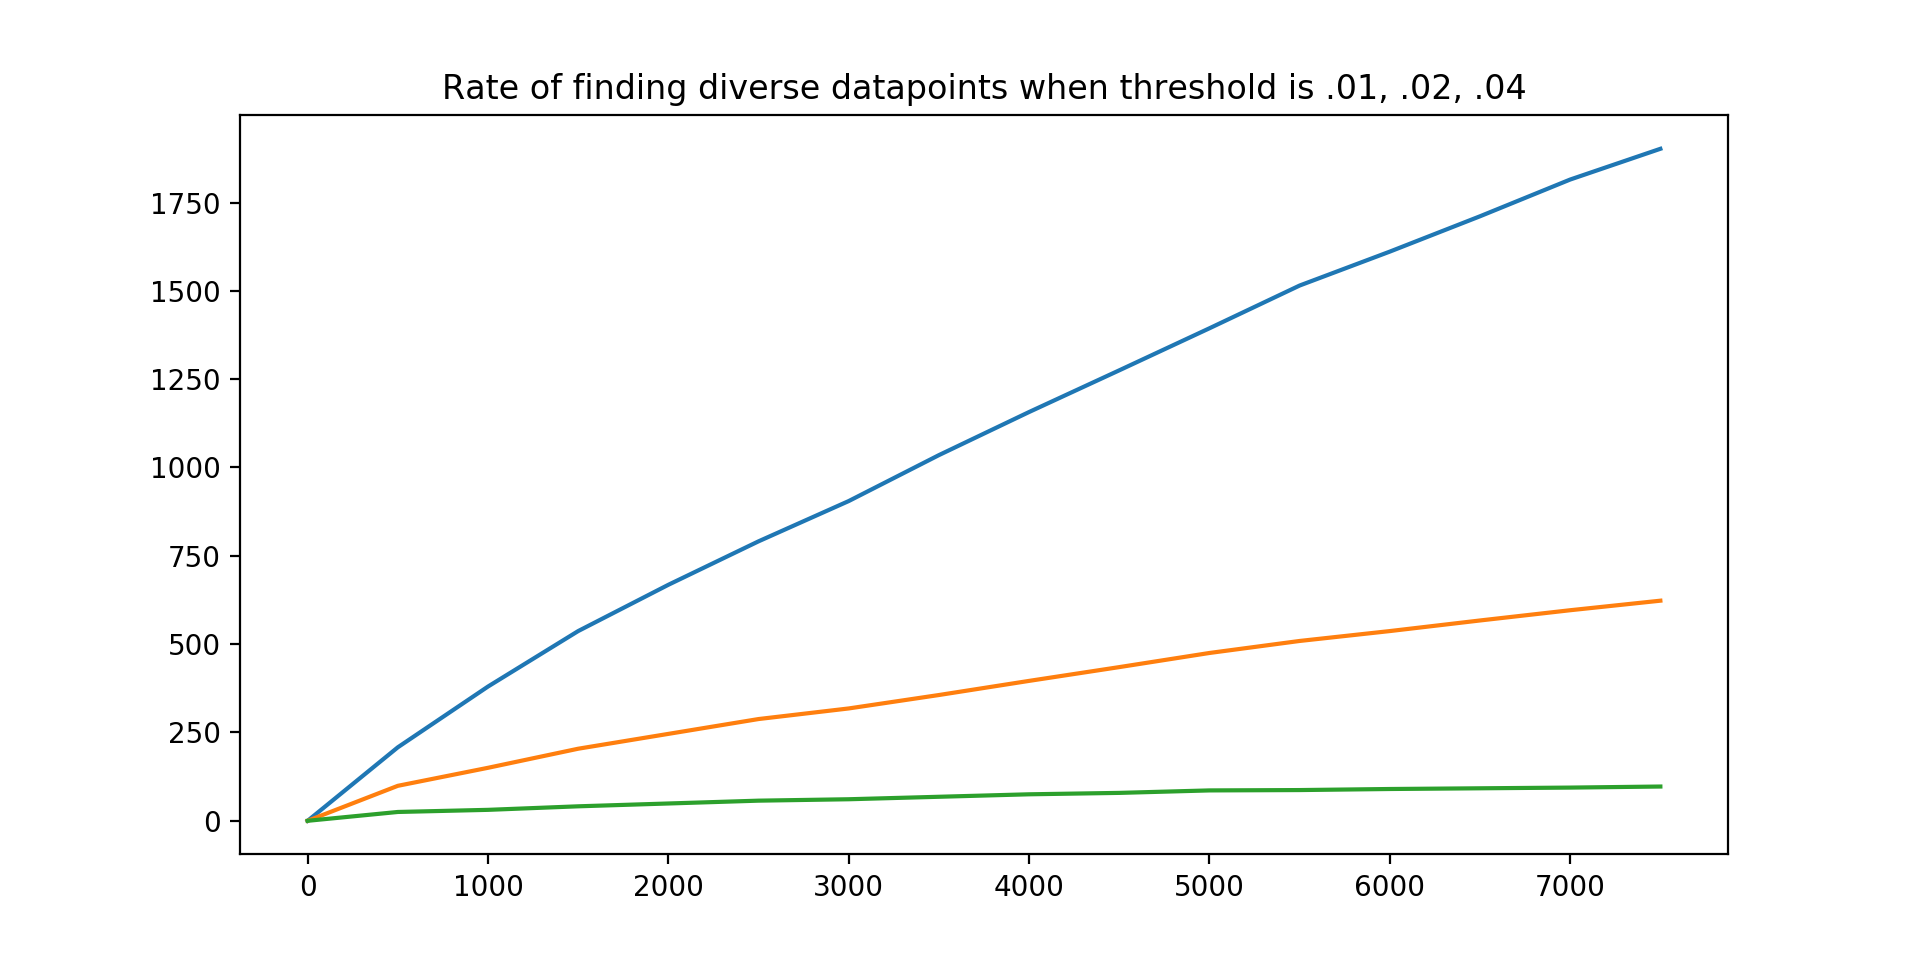

Text(0.5, 1.0, 'Rate of finding diverse datapoints when threshold is .01, .02, .04')

In [22]:
# Rate at which diverse data is added
# Ideally, to represent all of the curves, data should be added until the plot saturates
x=range(0,8000,500)
y_01=[0,208,380,537,668,791,905,1035,1157,1275,1394,1515,1611,1711,1815,1902]
y_02=[0,99,150,204,246,288,318,356,396,435,475,509,537,567,596,623]
y_04=[0,25,31,41,49,57,61,68,75,79,86,87,90,92,94,97]
fig = plt.figure(figsize=plt.figaspect(1/2))
ax = fig.add_subplot(111)
ax.plot(x,y_01)
ax.plot(x,y_02)
ax.plot(x,y_04)
ax.set_title("Rate of finding diverse datapoints when threshold is .01, .02, .04")

# Store the Diverse Normalized Database

In [23]:
np.savez('norm_database5SS', cplrData=DiverseCplrPathList, mechData=DiverseMechList) 

In [24]:
db = np.load('norm_database5SS.npz')

In [25]:
db.files

['cplrData', 'mechData']

In [26]:
print(db['cplrData'].shape)
print(db['mechData'].shape)

(1902, 100, 3)
(1902, 11, 3)
